# Resources and credit:
- SSDD data download: https://github.com/TianwenZhang0825/LS-SSDD-v1.0-OPEN
- Detectron2 docs: https://detectron2.readthedocs.io/en/latest/index.html
- Conceptual: https://medium.com/@hirotoschwert/digging-into-detectron-2-part-5-6e220d762f9
- Conceptual: https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

# Installation of detectron2 and Imports
*Standard from Detectron2's docs*

*Restart after executing this cell*

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")
!gcc --version
# opencv is pre-installed on colab
exit(0)

     |████████████████████████████████| 276kB 17.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=d0ad902caa2aec41f5919f073e730e81256b122c2023261f70688ee52a8ac4ea
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



*Restart after executing this cell*

In [1]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2==0.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
import detectron2
print(detectron2.__version__)
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 708kB/s 
     |████████████████████████████████| 2.2MB 33.3MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for iopath: filename=iopath-0.1.6-cp37-none-any.whl size=18269 sha256=bed5770f548f482210503234d413251d583c86d00215b7268bda146ff5498eb2
  Stored in directory: /root/.cache/pip/wheels/ff/87/55/7513122394822977f993e1798bfebb46730d6183df8db7b283
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210311-cp37-none-any.whl size=58461 sha256=d56d34ab8fcda7ab98696a489c4574f6bf2fec73ade8467afe9f13bf859f9c89
  Stored in directory: /root/.cache/pip/wheels/bc/cc/93/e011d6b86d91631d948f9bda94d60b82b51302192eb8a688c8
Successfully built iopath fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

0.4


In [1]:
!nvidia-smi

Mon Mar 15 01:17:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Registration of the custom dataset to detectron2

In [3]:
# Function that retrieves a standard dataset compatible with detectron2
def get_dict(type):
  """ Returns a list[dict] containing information about the dataset """
  import pickle
  root = '/content/drive/MyDrive/SSDD/datasets/' + type + '/'
  with open(root + "standardDict.pkl", "rb") as input_file:
    return pickle.load(input_file)

In [4]:
# Global paths
datasets = '/content/drive/MyDrive/SSDD/datasets/'

# Mount Google Drive (Import files from Google Drive in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from detectron2.structures import BoxMode

pre = 'ssdd_'

# Register
for d in ["train", "test", "test_offshore", "test_inshore", "train/train_w_val", "train/validation", "train/toy"]:
    DatasetCatalog.register(pre + d, lambda d=d: get_dict(d))
    MetadataCatalog.get(pre + d).set(thing_classes=["ship"])

In [6]:
# Instances of metadata
train_metadata = MetadataCatalog.get(pre + 'train')
test_metadata = MetadataCatalog.get(pre + 'test')
test_offshore_metadata = MetadataCatalog.get(pre + 'test_offshore')
test_inshore_metadata = MetadataCatalog.get(pre + 'test_inshore')
train_w_val_metadata = MetadataCatalog.get(pre + 'train/train_w_val')
validation_metadata = MetadataCatalog.get(pre + 'train/validation')
toy_metadata = MetadataCatalog.get(pre + 'train/toy')

# Model Loading

In [7]:
%cd /content/drive/MyDrive/SSDD/
output = '/content/drive/MyDrive/SSDD/'
model_name = "./ModelOutput/faster_rcnn_R_101_FPN_3x_5CO"  # Replace w/ folder

/content/drive/.shortcut-targets-by-id/1wPXpOTgpvbBJv06iD212UCxoZiCPIgEH/SSDD


In [8]:
from detectron2.engine import DefaultTrainer
# detectron2.config - https://detectron2.readthedocs.io/en/latest/modules/config.html

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))  # Replace w/ config
cfg.DATASETS.TRAIN = (pre + "train/train_w_val",)  # (pre + "train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ship)
cfg.OUTPUT_DIR = model_name

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # (default: 0.05)
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5  # (default: 0.5)

#cfg.MODEL.DEVICE = 'cpu'

In [9]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

[03/15 01:18:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Evaluation using the trained model

To run inference using the trained model on the validation/test dataset, we first create a predictor using the model we just trained.

In [10]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Load custom weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # (default: 0.05)
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5  # (default: 0.5)

predictor = DefaultPredictor(cfg)

## Visualization

We randomly select several samples to visualize the prediction results.

In [11]:
#from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict("test")   # must be "test", "test_offshore", "test_inshore"

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['annotations'] != []:
    dataset_dicts_anns.append(i)

In [12]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  #from detectron2.utils.visualizer import Visualizer

  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1],
                 metadata=metadata,
                 scale=0.5)
  
  if predFlag:
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  
  image = out.get_image()[:, :, ::-1]

  return image

In [13]:
os.makedirs(model_name + "/predImages_eval", exist_ok=True)  # Make a directory for output images

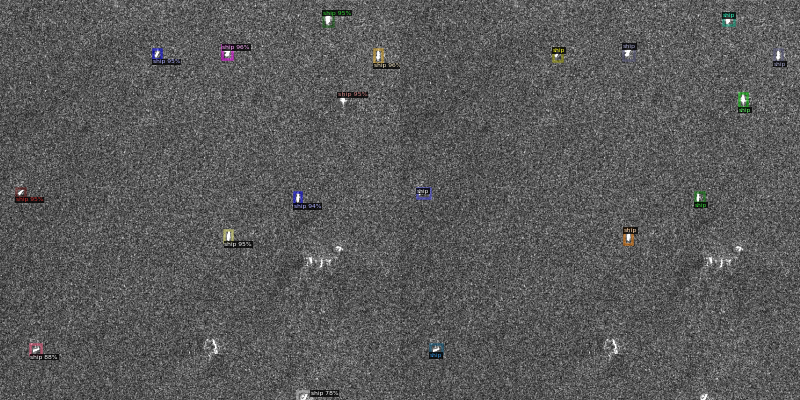

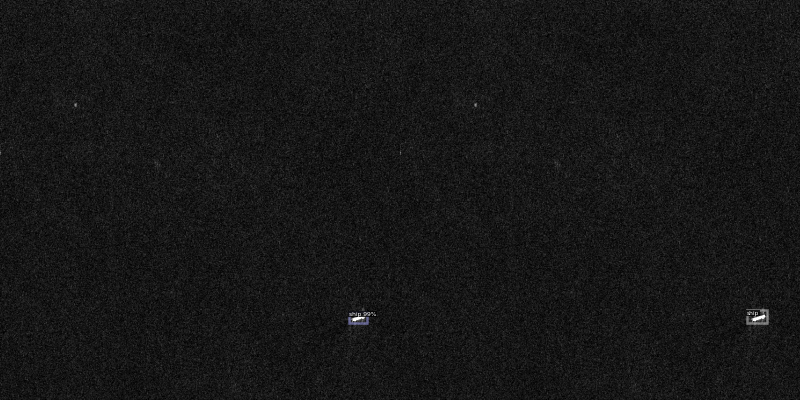

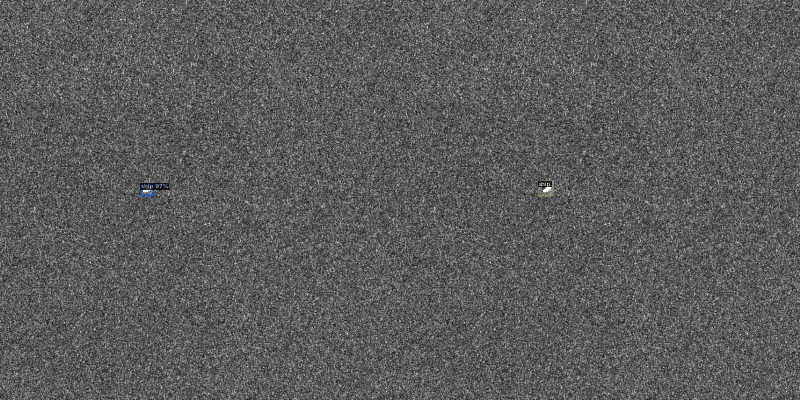

In [14]:
from cv2 import hconcat
random.seed(1)
#set.seed(1)

num_samples = 3

for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3) # display an image
  cv2.imwrite(model_name + '/predImages_eval/' + str(d["image_id"] + '.jpg'), image3)  # save an image

# Evaluation using the COCO Evaluator

We can also evaluate its performance using AP metric implemented in COCO API.

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [16]:
# test_offshore
evaluator = COCOEvaluator('ssdd_test_offshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/15 01:19:39 d2.evaluation.coco_evaluation]: 'ssdd_test_offshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[03/15 01:19:39 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_offshore' to COCO format ...)
[03/15 01:19:51 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/15 01:19:51 d2.data.datasets.coco]: Conversion finished, #images: 2234, #annotations: 1495
[03/15 01:19:51 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_5CO/ssdd_test_offshore_coco_format.json' ...
[03/15 01:19:51 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 1495         |
|            |              |
[03/15 01:19:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 01:19:53 d2.evaluation.evaluator]: Inference done 11/2234. 0.1039 s / img. ETA=0:04:09
[03/15 01:19:58 d2.evaluation.evaluator]: Inference done 59/2234. 0.1026 s / img. ETA=0:03:48
[03/15 01:20:03 d2.evaluation.evaluator]: Inference done 107/2234. 0.1024 s / img. ETA=0:03:42
[03/15 01:20:08 d2.evaluation.evaluator]: Inference done 155/2234. 0.1027 s / img. ETA=0:03:38
[03/15 01:20:13 d2.evaluation.evaluator]: Inference done 203/2234. 0.1029 s / img. ETA=0:03:33
[03/15 01:20:18 d2.evaluation.evaluator]: Inference done 250/2234. 0.1032 s / img. ETA=0:03:28
[03/15 01:20:23 d2.evaluation.evaluator]: Inference done 298/2234. 0.1034 s / img. ETA=0:03:24
[03/15 01:20:28 d2.evaluation.evaluator]: Inference done 346/2234. 0.1036 s / img. ETA=0:03:19
[03/15 01:20:34 d2.evaluation.evaluator]: Inference done 393/2234. 0.1038 s / img. ETA=0:03:14
[03/15 01:20:39 d2.evaluation.evaluator]: Inference done 440/2234. 0.1040 s / img. ETA=0:03:10
[03/15 01:20:44 d2.evaluation.evaluator]: Inference 

In [17]:
# test
evaluator = COCOEvaluator('ssdd_test', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/15 01:24:01 d2.evaluation.coco_evaluation]: 'ssdd_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[03/15 01:24:01 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test' to COCO format ...)
[03/15 01:24:01 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/15 01:24:02 d2.data.datasets.coco]: Conversion finished, #images: 3000, #annotations: 2378
[03/15 01:24:02 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_5CO/ssdd_test_coco_format.json' ...
[03/15 01:24:02 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 2378         |
|            |              |
[03/15 01:24:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/15 01:24:02 d2.data.com

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 01:24:06 d2.evaluation.evaluator]: Inference done 29/3000. 0.1138 s / img. ETA=0:05:42
[03/15 01:24:11 d2.evaluation.evaluator]: Inference done 73/3000. 0.1134 s / img. ETA=0:05:37
[03/15 01:24:16 d2.evaluation.evaluator]: Inference done 117/3000. 0.1134 s / img. ETA=0:05:32
[03/15 01:24:21 d2.evaluation.evaluator]: Inference done 161/3000. 0.1134 s / img. ETA=0:05:27
[03/15 01:24:26 d2.evaluation.evaluator]: Inference done 205/3000. 0.1135 s / img. ETA=0:05:22
[03/15 01:24:31 d2.evaluation.evaluator]: Inference done 249/3000. 0.1136 s / img. ETA=0:05:17
[03/15 01:24:36 d2.evaluation.evaluator]: Inference done 293/3000. 0.1136 s / img. ETA=0:05:12
[03/15 01:24:41 d2.evaluation.evaluator]: Inference done 337/3000. 0.1136 s / img. ETA=0:05:07
[03/15 01:24:46 d2.evaluation.evaluator]: Inference done 381/3000. 0.1137 s / img. ETA=0:05:02
[03/15 01:24:51 d2.evaluation.evaluator]: Inference done 425/3000. 0.1137 s / img. ETA=0:04:57
[03/15 01:24:57 d2.evaluation.evaluator]: Inference 

In [18]:
# test_inshore
evaluator = COCOEvaluator('ssdd_test_inshore', ('bbox',), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/15 01:29:50 d2.evaluation.coco_evaluation]: 'ssdd_test_inshore' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[03/15 01:29:50 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_test_inshore' to COCO format ...)
[03/15 01:29:56 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/15 01:29:56 d2.data.datasets.coco]: Conversion finished, #images: 766, #annotations: 883
[03/15 01:29:56 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_5CO/ssdd_test_inshore_coco_format.json' ...
[03/15 01:29:56 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    ship    | 883          |
|            |              |
[03/15 01:29:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 01:29:58 d2.evaluation.evaluator]: Inference done 11/766. 0.1115 s / img. ETA=0:01:25
[03/15 01:30:03 d2.evaluation.evaluator]: Inference done 55/766. 0.1118 s / img. ETA=0:01:20
[03/15 01:30:08 d2.evaluation.evaluator]: Inference done 99/766. 0.1120 s / img. ETA=0:01:15
[03/15 01:30:13 d2.evaluation.evaluator]: Inference done 143/766. 0.1122 s / img. ETA=0:01:11
[03/15 01:30:18 d2.evaluation.evaluator]: Inference done 187/766. 0.1124 s / img. ETA=0:01:06
[03/15 01:30:23 d2.evaluation.evaluator]: Inference done 231/766. 0.1126 s / img. ETA=0:01:01
[03/15 01:30:28 d2.evaluation.evaluator]: Inference done 275/766. 0.1128 s / img. ETA=0:00:56
[03/15 01:30:33 d2.evaluation.evaluator]: Inference done 319/766. 0.1129 s / img. ETA=0:00:51
[03/15 01:30:38 d2.evaluation.evaluator]: Inference done 363/766. 0.1130 s / img. ETA=0:00:46
[03/15 01:30:43 d2.evaluation.evaluator]: Inference done 407/766. 0.1131 s / img. ETA=0:00:41
[03/15 01:30:49 d2.evaluation.evaluator]: Inference done 451/76

In [19]:
%ls ./ModelOutput/faster_rcnn_R_101_FPN_3x_5CO

coco_instances_results.json
events.out.tfevents.1615745995.79902d8b2b4e.181.0
events.out.tfevents.1615771126.f81a011d3781.202.0
instances_predictions.pth
last_checkpoint
metrics.json
model_0004999.pth
model_0009999.pth
model_0014999.pth
model_0019999.pth
model_0024999.pth
model_0029999.pth
model_final.pth
predImages_eval/
ssdd_test_coco_format.json
ssdd_test_coco_format.json.lock
ssdd_test_inshore_coco_format.json
ssdd_test_inshore_coco_format.json.lock
ssdd_test_offshore_coco_format.json
ssdd_test_offshore_coco_format.json.lock
Validation_eval/


# Evaluation using a Custom Evaluator

detectron2.evaluation.coco_evaluation: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/evaluation/coco_evaluation.html

detectron2.evaluation: https://detectron2.readthedocs.io/en/latest/modules/evaluation.html#

Evaluation: https://detectron2.readthedocs.io/en/latest/tutorials/evaluation.html

Evaluation:

https://github.com/facebookresearch/detectron2/blob/master/detectron2/evaluation/coco_evaluation.py
https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py

Concept:

https://cs230.stanford.edu/section/7/

https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173




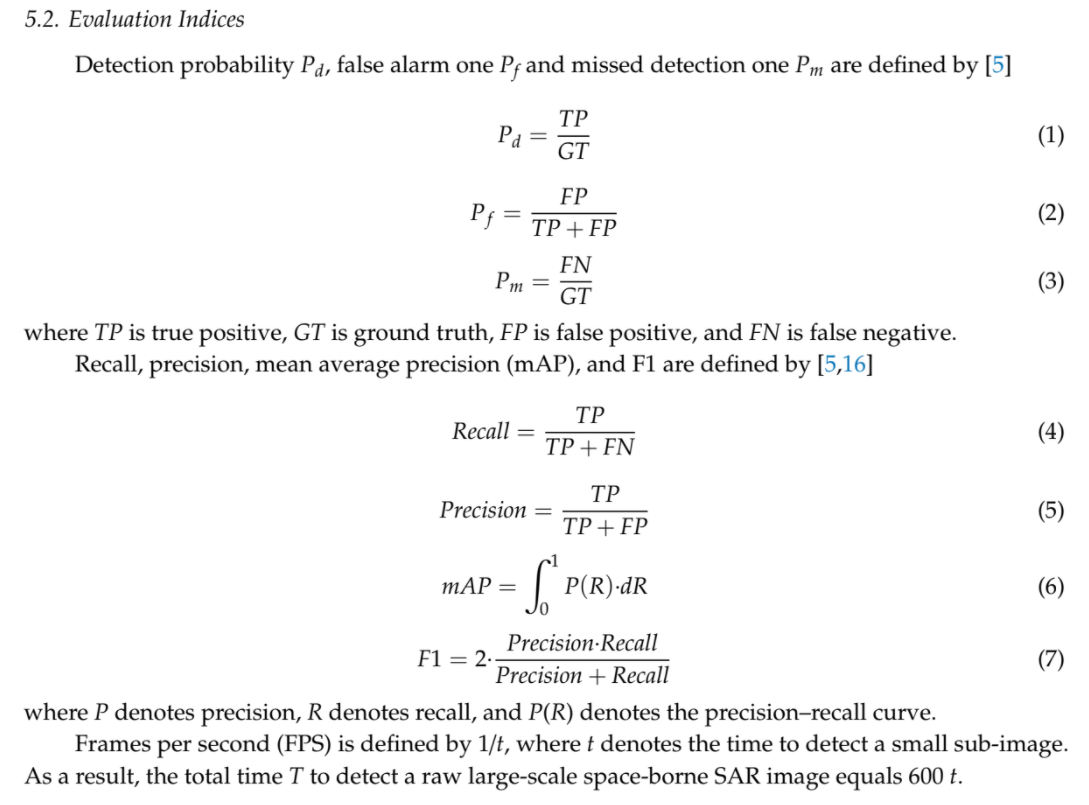


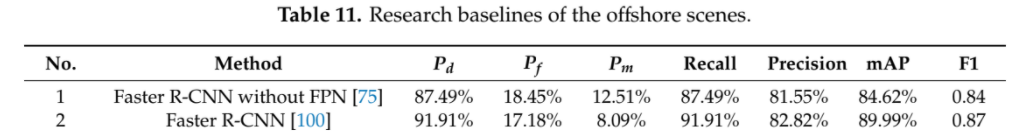

In [20]:
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation import DatasetEvaluator
from detectron2.utils.file_io import PathManager
from collections import OrderedDict
from pycocotools.coco import COCO
import itertools
import contextlib
import torch
import copy
import os
import io

In [21]:
def average_precision(correct, ground_truth):
  # correct contains True Positives (TP) and False Positives (FP)
  # ground_truth is the number of positive examples (TP + FN = GT)

  # precision = TP / (TP + FP)
  # recall = TP / (TP + FN) = TP / GT
  TP = 0
  FP = 0
  GT = ground_truth
  precision = []
  recall = []

  for i, c in enumerate(correct):
    if c:
      TP += 1
    else:
      FP += 1
    precision.append(TP / (TP + FP))
    if GT == 0:
      recall.append(0.0)
    else:
      recall.append(TP / GT)


  # Interpolate precision (replace each precision value with the maximum precision value to the right of that recall level)
  max = 0
  precision_interp = []

  for i, c in enumerate(reversed(precision)):
    if c > max:
      max = c
      precision_interp.append(c)
    else:
      precision_interp.append(max)
  
  precision_interp = list(reversed(precision_interp))


  # Calculate AP (Average Precision)
  AP = 0
  for i, c in enumerate(recall):
    if i == 0:
      continue
    AP += (recall[i] - recall[i-1]) * precision_interp[i]
  
  return recall, precision_interp, AP


# Test Case
#test = [True, True, False, False, False, True, True, False, False, True]
#recall, precision, AP = average_precision(test, 5)
#assert AP == 0.5285714285714286
#assert recall == [0.2, 0.4, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 0.8, 1.0]
#assert precision == [1.0, 
#                    1.0, 
#                    0.6666666666666666,
#                    0.5714285714285714,
#                    0.5714285714285714,
#                    0.5714285714285714,
#                    0.5714285714285714,
#                    0.5,
#                    0.5,
#                    0.5]

In [22]:
class CustomEvaluator(DatasetEvaluator):
  def __init__(
        self,
        dataset_name,
        output_dir
  ):
    """
    Args:
        dataset_name (str): name of the dataset to be evaluated.
            It must have either the following corresponding metadata:

                "json_file": the path to the COCO format annotation

            Or it must be in detectron2's standard dataset format
            so it can be converted to COCO format automatically.
        output_dir (str): an output directory to dump all
            results predicted on the dataset. The dump contains two files:

            1. "instances_predictions.pth" (dataset_name + "_predictions.pth")
                a file that can be loaded with `torch.load` and
                contains all the results in the format they are produced by the model.
            2. "coco_instances_results.json" a json file in COCO's result format.
    """
    self._cpu_device = torch.device("cpu")
    self.dataset_name = dataset_name
    self._metadata = MetadataCatalog.get(dataset_name)
    self._output_dir = output_dir
    
    if not hasattr(self._metadata, "json_file"):
      cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
      self._metadata.json_file = cache_path
      convert_to_coco_json(dataset_name, cache_path)

    json_file = PathManager.get_local_path(self._metadata.json_file)
    with contextlib.redirect_stdout(io.StringIO()):
        self._coco_api = COCO(json_file)

  def reset(self):
    """
    Preparation for a new round of evaluation.
    """
    self._predictions = []

  def process(self, inputs, outputs):
    """
    Process the pair of inputs and outputs.

    Args:
        inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
            It is a list of dict. Each dict corresponds to an image and
            contains keys like "height", "width", "file_name", "image_id".
        outputs: the outputs of a COCO model. It is a list of dicts with key
            "instances" that contains :class:`Instances`.
    """
    for input, output in zip(inputs, outputs):
      prediction = {"image_id": input["image_id"]}
      if "instances" in output:
          prediction["instances"] = output["instances"].to(self._cpu_device) 
      if len(prediction) > 1:
          self._predictions.append(prediction)
    
    if self._output_dir:
      PathManager.mkdirs(self._output_dir)
      file_path = os.path.join(self._output_dir,
                               self.dataset_name + "_predictions.pth")
#      file_path = os.path.join(self._output_dir, "instances_predictions.pth")
#      file_path = os.path.join(self._output_dir, f"{dataset_name}_predictions.pth") # NameError: name 'dataset_name' is not defined

      with PathManager.open(file_path, "wb") as f:
        torch.save(self._predictions, f)

  def evaluate(self):
    """
    Evaluate/summarize the performance, after processing all input/output pairs.
    Evaluates on the whole dataset.
    """
    iou_threshold = 0.5
    num_instances = 0
    num_pos = 0  # must be equal to GT
    gt_overlaps = []
#    ap = [] 
    scores = []
    correct = []
    bad_images = []

    if len(self._predictions) == 0:
      return {}, {}, {}

    # Loop over all instances in one image
    for prediction_dict in self._predictions:
      predictions = prediction_dict["instances"]
      num_instances += len(predictions)

      # Get scores of each instance, sort in descending order
      inds = predictions.get_fields()['scores'].sort(descending=True)[1]
      in_scores = predictions.get_fields()['scores']
      in_scores = in_scores[inds]
      
      # Get bbox of each instance, sort by score
      in_boxes = predictions.get_fields()['pred_boxes']
      in_boxes = in_boxes[inds]

      assert len(in_boxes) == len(in_scores) == len(predictions)

      # Retrieve corresponding ground truth boxes/labels
      ann_ids = self._coco_api.getAnnIds(imgIds=[prediction_dict["image_id"]])
      anno = self._coco_api.loadAnns(ann_ids)
      gt_boxes = [
          BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
          for obj in anno
          if obj["iscrowd"] == 0
      ]
      gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)
      gt_boxes = Boxes(gt_boxes)

#      if len(predictions) == 0 or len(gt_boxes) == 0:
#        continue

      num_pos += len(gt_boxes)
      
      # Compute IOU for each instance-ground truth pair
      overlaps = pairwise_iou(in_boxes, gt_boxes)

      _gt_overlaps = torch.zeros(len(gt_boxes)) # stores iou for each gt box in one image
      _scores = torch.zeros(len(in_scores)) # stores iou for each proposal box (score) in one image

      # Ensure 1-1 mapping between prediction and gt boxes
      for j in range(min(len(predictions), len(gt_boxes))):
          # find which proposal box maximally covers each gt box
          # and get the iou amount of coverage for each gt box
          max_overlaps, argmax_overlaps = overlaps.max(dim=0)
          
          # find which gt box is 'best' covered (i.e. 'best' = most iou)
          gt_ovr, gt_ind = max_overlaps.max(dim=0)
          assert gt_ovr >= 0

          # find the proposal box that covers the best covered gt box
          box_ind = argmax_overlaps[gt_ind]

          # record the iou coverage of this gt box
          _gt_overlaps[j] = overlaps[box_ind, gt_ind]  # _gt_overlaps[gt_ind] ?
          assert _gt_overlaps[j] == gt_ovr  # _gt_overlaps[gt_ind] ?

          # record this iou coverage for score
          _scores[box_ind] = overlaps[box_ind, gt_ind]
          assert _scores[box_ind] == gt_ovr

          # mark the proposal box and the gt box as used
          overlaps[box_ind, :] = -1
          overlaps[:, gt_ind] = -1
      
      # update collectors
      _correct = (_scores >= iou_threshold).tolist() # stores TP/FP for each proposal box in one image

      assert len(_correct) == len(_scores) == len(predictions)

      if _correct and sum(np.invert(_correct)) > 0:
        bad_images.append(prediction_dict)
      
#      _, __, _ap = average_precision(_correct, len(gt_boxes))

      # append recorded iou coverage level
      gt_overlaps.append(_gt_overlaps)
      scores.append(in_scores)
      correct.append(_correct)
#      ap.append(_ap)


    # all images
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps)
         else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps, descending = True)

    scores = (
        torch.cat(scores, dim=0) if len(scores)
         else torch.zeros(0, dtype=torch.float32)
    )
    scores, ind = torch.sort(scores, descending = True)
    
    # stores TP/FP for each proposal box in all images (in descending order of scores)
    correct = list(itertools.chain.from_iterable(correct))
    assert len(scores) == len(correct)
    correct = [correct[i] for i in ind.tolist()]

    # The following metrics are computed at iou_threshold
    GT = len(self._coco_api.getAnnIds())
    assert GT == num_pos

    TP = np.sum(np.array(correct))
    FP = len(correct) - TP
    assert (TP + FP) == num_instances
    FN = GT - TP

    Pd = TP / GT          # Detection probability
    Pf = FP / (TP + FP)   # false alarm
    Pm = FN / GT          # missed detection
    # assert (Pd + Pm) == 1

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = 2 * (precision * recall) / (precision + recall)
#    meanAP = np.array(ap).mean()
    recalls, precisions, mAP = average_precision(correct, GT)

    plot = {"recalls": recalls, "precisions": precisions}
    hist = {"gt_overlap": gt_overlaps, "scores": scores}
    self._results = {
        "TP": TP,
        "FP": FP,
        "GT": GT,
        "FN": FN,
        "Pd": Pd,
        "Pf": Pf,
        "Pm": Pm,
        "recall": recall,
        "precision": precision,
        "mAP": mAP,
        "F1": F1
    }
    
    return copy.deepcopy(self._results), plot, hist, bad_images

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#val = './datasets/test/'

In [24]:
# test_inshore
custEval = CustomEvaluator('ssdd_test_inshore', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_inshore')

inference = inference_on_dataset(trainer.model, val_loader, custEval)

[03/15 01:32:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/15 01:32:05 d2.data.common]: Serializing 766 elements to byte tensors and concatenating them all ...
[03/15 01:32:05 d2.data.common]: Serialized dataset takes 0.14 MiB
[03/15 01:32:05 d2.evaluation.evaluator]: Start inference on 766 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 01:32:07 d2.evaluation.evaluator]: Inference done 11/766. 0.1059 s / img. ETA=0:01:24
[03/15 01:32:12 d2.evaluation.evaluator]: Inference done 54/766. 0.1059 s / img. ETA=0:01:23
[03/15 01:32:17 d2.evaluation.evaluator]: Inference done 96/766. 0.1059 s / img. ETA=0:01:19
[03/15 01:32:22 d2.evaluation.evaluator]: Inference done 138/766. 0.1056 s / img. ETA=0:01:15
[03/15 01:32:27 d2.evaluation.evaluator]: Inference done 178/766. 0.1055 s / img. ETA=0:01:11
[03/15 01:32:32 d2.evaluation.evaluator]: Inference done 218/766. 0.1053 s / img. ETA=0:01:07
[03/15 01:32:37 d2.evaluation.evaluator]: Inference done 256/766. 0.1052 s / img. ETA=0:01:03
[03/15 01:32:42 d2.evaluation.evaluator]: Inference done 294/766. 0.1052 s / img. ETA=0:00:59
[03/15 01:32:47 d2.evaluation.evaluator]: Inference done 330/766. 0.1051 s / img. ETA=0:00:55
[03/15 01:32:52 d2.evaluation.evaluator]: Inference done 367/766. 0.1050 s / img. ETA=0:00:51
[03/15 01:32:57 d2.evaluation.evaluator]: Inference done 403/76

In [25]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.4897959183673469,
 'FN': 535,
 'FP': 190,
 'GT': 883,
 'Pd': 0.3941109852774632,
 'Pf': 0.35315985130111527,
 'Pm': 0.6058890147225368,
 'TP': 348,
 'mAP': 0.3304600053475179,
 'precision': 0.6468401486988847,
 'recall': 0.3941109852774632}

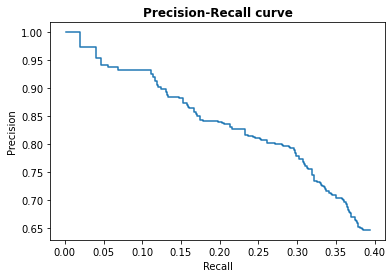

In [26]:
# Precision-Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve', fontweight ="bold")
plt.show()

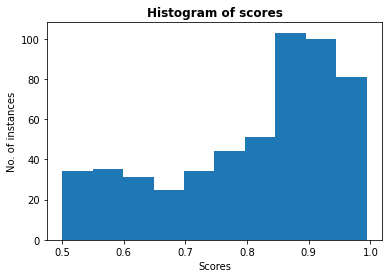

In [27]:
# Histogram of scores for all instances
plt.hist(hist['scores'])
plt.xlabel('Scores')
plt.ylabel('No. of instances')
plt.title('Histogram of scores', fontweight ="bold")
plt.show()

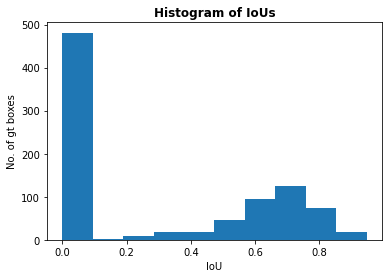

In [28]:
# Histogram of IoUs for all matching instances/gt boxes
plt.hist(hist['gt_overlap'])
plt.xlabel('IoU')
plt.ylabel('No. of gt boxes')
plt.title('Histogram of IoUs', fontweight ="bold")
plt.show()

In [29]:
# test_offshore
custEval = CustomEvaluator('ssdd_test_offshore', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test_offshore')

inference = inference_on_dataset(trainer.model, val_loader, custEval)

[03/15 01:33:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/15 01:33:57 d2.data.common]: Serializing 2234 elements to byte tensors and concatenating them all ...
[03/15 01:33:57 d2.data.common]: Serialized dataset takes 0.41 MiB
[03/15 01:33:57 d2.evaluation.evaluator]: Start inference on 2234 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 01:33:58 d2.evaluation.evaluator]: Inference done 12/2234. 0.1110 s / img. ETA=0:04:19
[03/15 01:34:03 d2.evaluation.evaluator]: Inference done 53/2234. 0.1093 s / img. ETA=0:04:24
[03/15 01:34:08 d2.evaluation.evaluator]: Inference done 95/2234. 0.1088 s / img. ETA=0:04:19
[03/15 01:34:13 d2.evaluation.evaluator]: Inference done 135/2234. 0.1086 s / img. ETA=0:04:17
[03/15 01:34:19 d2.evaluation.evaluator]: Inference done 175/2234. 0.1084 s / img. ETA=0:04:15
[03/15 01:34:24 d2.evaluation.evaluator]: Inference done 213/2234. 0.1084 s / img. ETA=0:04:14
[03/15 01:34:29 d2.evaluation.evaluator]: Inference done 250/2234. 0.1082 s / img. ETA=0:04:12
[03/15 01:34:34 d2.evaluation.evaluator]: Inference done 287/2234. 0.1081 s / img. ETA=0:04:09
[03/15 01:34:39 d2.evaluation.evaluator]: Inference done 324/2234. 0.1080 s / img. ETA=0:04:07
[03/15 01:34:44 d2.evaluation.evaluator]: Inference done 359/2234. 0.1079 s / img. ETA=0:04:05
[03/15 01:34:49 d2.evaluation.evaluator]: Inference d

In [30]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.8711493872143093,
 'FN': 180,
 'FP': 209,
 'GT': 1495,
 'Pd': 0.8795986622073578,
 'Pf': 0.13713910761154854,
 'Pm': 0.12040133779264214,
 'TP': 1315,
 'mAP': 0.8468015527906496,
 'precision': 0.8628608923884514,
 'recall': 0.8795986622073578}

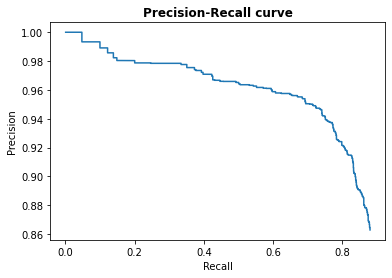

In [31]:
# Precision-Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve', fontweight ="bold")
plt.show()

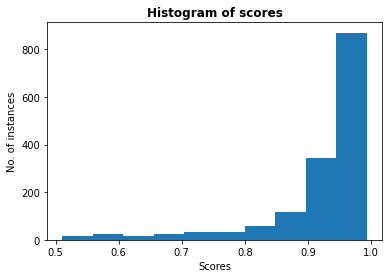

In [32]:
# Histogram of scores for all instances
plt.hist(hist['scores'])
plt.xlabel('Scores')
plt.ylabel('No. of instances')
plt.title('Histogram of scores', fontweight ="bold")
plt.show()

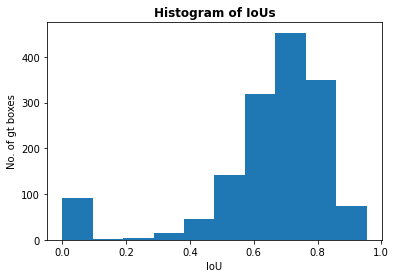

In [33]:
# Histogram of IoUs for all matching instances/gt boxes
plt.hist(hist['gt_overlap'])
plt.xlabel('IoU')
plt.ylabel('No. of gt boxes')
plt.title('Histogram of IoUs', fontweight ="bold")
plt.show()

In [34]:
# test
custEval = CustomEvaluator('ssdd_test', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_test')

inference = inference_on_dataset(trainer.model, val_loader, custEval)

[03/15 01:41:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/15 01:41:50 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[03/15 01:41:50 d2.data.common]: Serialized dataset takes 0.53 MiB
[03/15 01:41:50 d2.evaluation.evaluator]: Start inference on 3000 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 01:41:51 d2.evaluation.evaluator]: Inference done 11/3000. 0.1059 s / img. ETA=0:05:57
[03/15 01:41:56 d2.evaluation.evaluator]: Inference done 53/3000. 0.1062 s / img. ETA=0:05:54
[03/15 01:42:01 d2.evaluation.evaluator]: Inference done 94/3000. 0.1059 s / img. ETA=0:05:53
[03/15 01:42:06 d2.evaluation.evaluator]: Inference done 135/3000. 0.1058 s / img. ETA=0:05:49
[03/15 01:42:12 d2.evaluation.evaluator]: Inference done 175/3000. 0.1058 s / img. ETA=0:05:47
[03/15 01:42:17 d2.evaluation.evaluator]: Inference done 214/3000. 0.1056 s / img. ETA=0:05:46
[03/15 01:42:22 d2.evaluation.evaluator]: Inference done 252/3000. 0.1056 s / img. ETA=0:05:45
[03/15 01:42:27 d2.evaluation.evaluator]: Inference done 290/3000. 0.1056 s / img. ETA=0:05:43
[03/15 01:42:32 d2.evaluation.evaluator]: Inference done 325/3000. 0.1055 s / img. ETA=0:05:44
[03/15 01:42:37 d2.evaluation.evaluator]: Inference done 361/3000. 0.1054 s / img. ETA=0:05:42
[03/15 01:42:42 d2.evaluation.evaluator]: Inference d

In [35]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.7490990990990991,
 'FN': 715,
 'FP': 399,
 'GT': 2378,
 'Pd': 0.69932716568545,
 'Pf': 0.19350145489815712,
 'Pm': 0.30067283431455005,
 'TP': 1663,
 'mAP': 0.6632230679612467,
 'precision': 0.8064985451018428,
 'recall': 0.69932716568545}

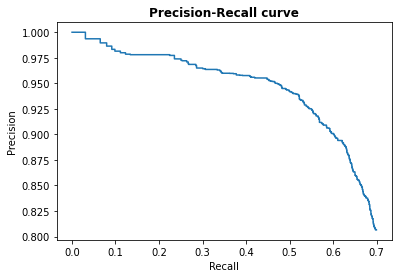

In [36]:
# Precision-Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve', fontweight ="bold")
plt.show()

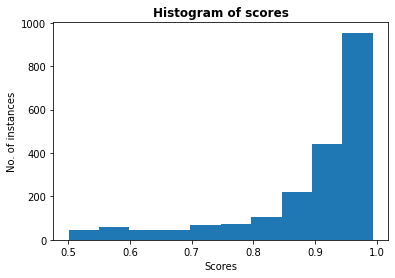

In [37]:
# Histogram of scores for all instances
plt.hist(hist['scores'])
plt.xlabel('Scores')
plt.ylabel('No. of instances')
plt.title('Histogram of scores', fontweight ="bold")
plt.show()

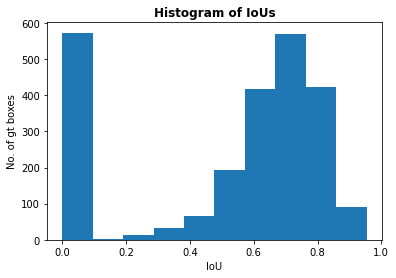

In [38]:
# Histogram of IoUs for all matching instances/gt boxes
plt.hist(hist['gt_overlap'])
plt.xlabel('IoU')
plt.ylabel('No. of gt boxes')
plt.title('Histogram of IoUs', fontweight ="bold")
plt.show()

In [39]:
# train_w_val
custEval = CustomEvaluator('ssdd_train/train_w_val', output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'ssdd_train/train_w_val')

inference = inference_on_dataset(trainer.model, val_loader, custEval)

[03/15 01:54:09 d2.data.datasets.coco]: Converting annotations of dataset 'ssdd_train/train_w_val' to COCO format ...)
[03/15 01:54:09 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/15 01:54:09 d2.data.datasets.coco]: Conversion finished, #images: 5100, #annotations: 2994
[03/15 01:54:09 d2.data.datasets.coco]: Caching COCO format annotations at './ModelOutput/faster_rcnn_R_101_FPN_3x_5CO/ssdd_train/train_w_val_coco_format.json' ...
[03/15 01:54:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/15 01:54:10 d2.data.common]: Serializing 5100 elements to byte tensors and concatenating them all ...
[03/15 01:54:10 d2.data.common]: Serialized dataset takes 0.86 MiB
[03/15 01:54:10 d2.evaluation.evaluator]: Start inference on 5100 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[03/15 01:54:12 d2.evaluation.evaluator]: Inference done 11/5100. 0.1054 s / img. ETA=0:11:13
[03/15 01:54:17 d2.evaluation.evaluator]: Inference done 54/5100. 0.1045 s / img. ETA=0:09:56
[03/15 01:54:22 d2.evaluation.evaluator]: Inference done 95/5100. 0.1041 s / img. ETA=0:10:04
[03/15 01:54:27 d2.evaluation.evaluator]: Inference done 136/5100. 0.1039 s / img. ETA=0:10:03
[03/15 01:54:32 d2.evaluation.evaluator]: Inference done 175/5100. 0.1038 s / img. ETA=0:10:07
[03/15 01:54:37 d2.evaluation.evaluator]: Inference done 211/5100. 0.1036 s / img. ETA=0:10:17
[03/15 01:54:42 d2.evaluation.evaluator]: Inference done 247/5100. 0.1034 s / img. ETA=0:10:22
[03/15 01:54:47 d2.evaluation.evaluator]: Inference done 284/5100. 0.1034 s / img. ETA=0:10:23
[03/15 01:54:52 d2.evaluation.evaluator]: Inference done 320/5100. 0.1034 s / img. ETA=0:10:24
[03/15 01:54:57 d2.evaluation.evaluator]: Inference done 354/5100. 0.1034 s / img. ETA=0:10:28
[03/15 01:55:02 d2.evaluation.evaluator]: Inference d

In [40]:
# Alternatively, load predictions directly from file into custEval instance
temp = torch.load(os.path.join(cfg.OUTPUT_DIR, "ssdd_train/train_w_val_predictions.pth"))
custEval._predictions = temp

In [41]:
eval, plot, hist, bad_images = custEval.evaluate()
eval

{'F1': 0.7476346120763805,
 'FN': 821,
 'FP': 646,
 'GT': 2994,
 'Pd': 0.7257849031396125,
 'Pf': 0.22915927633912736,
 'Pm': 0.2742150968603874,
 'TP': 2173,
 'mAP': 0.6879207301172878,
 'precision': 0.7708407236608726,
 'recall': 0.7257849031396125}

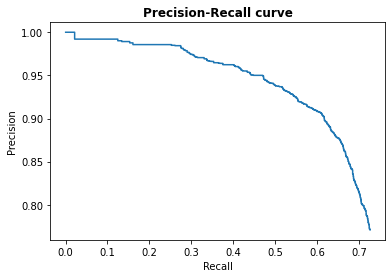

In [42]:
# Precision-Recall Curve
plt.plot(plot['recalls'], plot['precisions'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve', fontweight ="bold")
plt.show()

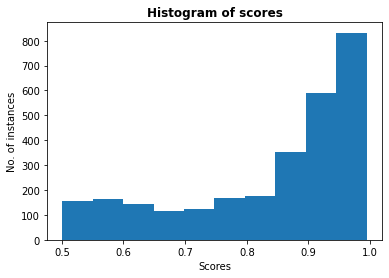

In [43]:
# Histogram of scores for all instances
plt.hist(hist['scores'])
plt.xlabel('Scores')
plt.ylabel('No. of instances')
plt.title('Histogram of scores', fontweight ="bold")
plt.show()

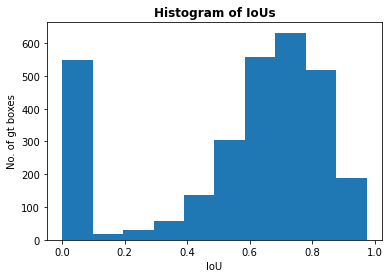

In [45]:
# Histogram of IoUs for all matching instances/gt boxes
plt.hist(hist['gt_overlap'])
plt.xlabel('IoU')
plt.ylabel('No. of gt boxes')
plt.title('Histogram of IoUs', fontweight ="bold")
plt.show()

# Evaluation using the trained model

To run inference using the trained model on the validation/test dataset, we first create a predictor using the model we just trained.

In [46]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") # Load custom weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # (default: 0.05)
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5  # (default: 0.5)

predictor = DefaultPredictor(cfg)

## Visualization

Output images where predictions are wrong for error analysis.

In [47]:
#from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_dict("train/train_w_val")   # must be "test", "test_offshore", "test_inshore"

bad_images_ind = [i['image_id'] for i in bad_images]

# Filter out pics w/o annotations
dataset_dicts_anns = []
for i in dataset_dicts:
  if i['image_id'] in bad_images_ind:
    dataset_dicts_anns.append(i)

In [48]:
len(dataset_dicts_anns)

302

In [49]:
def printImage(ann, metadata, predictor = None, predFlag = False):
  #from detectron2.utils.visualizer import Visualizer

  im = cv2.imread(ann["file_name"])
  v = Visualizer(im[:, :, ::-1], 
                 metadata=metadata, 
                 scale=0.5)
  
  if predFlag:
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  else:
    out = v.draw_dataset_dict(ann)
  
  image = out.get_image()[:, :, ::-1]

  return image

In [50]:
os.makedirs(model_name + "/predImages_eval_bad", exist_ok=True)  # Make a directory for output images

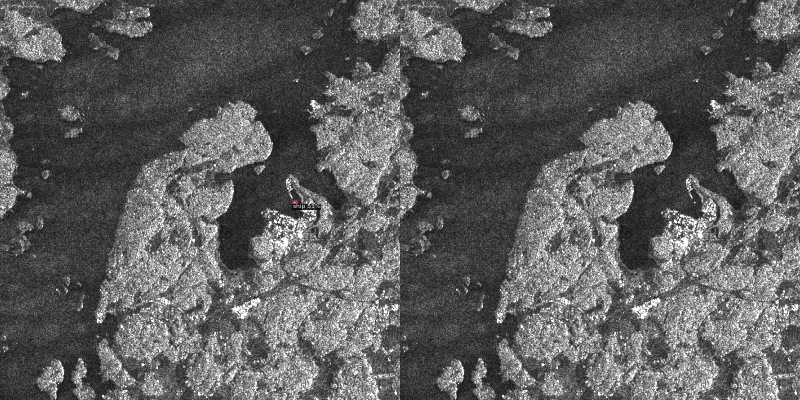

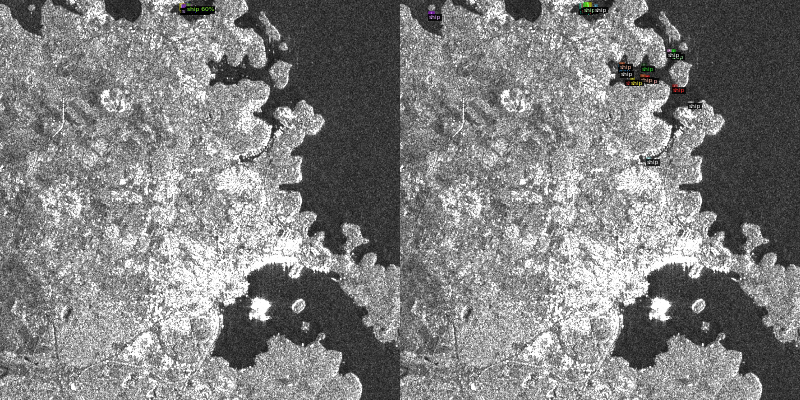

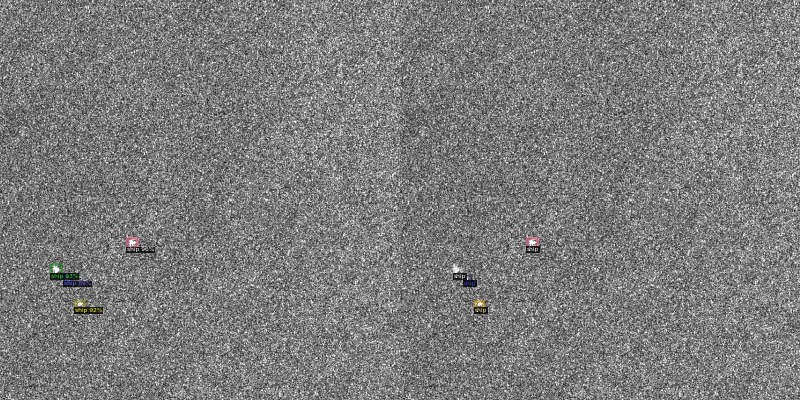

In [56]:
from cv2 import hconcat
#random.seed(1)
#set.seed(1)

num_samples = 3
#num_samples = len(dataset_dicts_anns)

for d in random.sample(dataset_dicts_anns, num_samples):
  image1 = printImage(d, test_metadata, predictor, True)  # Prediction
  image2 = printImage(d, test_metadata, False)  # Ground truth
  image3 = hconcat([image1, image2])

  cv2_imshow(image3) # display an image
  cv2.imwrite(model_name + '/predImages_eval_bad/' + str(d["image_id"] + '.jpg'), image3)  # save an image